<a href="https://colab.research.google.com/github/GeraDLC/Financial_Fraud_Detection/blob/main/Financial_Fraud_Detection_BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




La urgencia por detectar fraudes en transacciones móviles de dinero ha llevado a una empresa del segmento Fintech a buscar soluciones innovadoras. Como científicos de datos hemos sido convocados para desarrollar un modelo de machine learning que pueda distinguir de manera precisa entre transacciones legítimas y fraudulentas, estableciendo así un estándar de seguridad en el sector financiero móvil global.

### **Tus tareas principales serán:**

**1. Preprocesamiento de Datos:** Realizar limpieza de datos, manejar valores faltantes, codificación de variables categóricas y normalización/escalado de datos.

**2. Exploración de Datos:** Analizar y comprender el conjunto de datos proporcionado, identificar variables llaves y realizar visualizaciones para entender las relaciones entre las variables y seleccionar las características relevantes.

**3. Construcción de Modelos:** Experimentar con algunos algoritmos de machine learning como Regresión Logística, Árboles de Decisión, Random Forest, Naive Bayes, entre otros.

**4. Evaluación y Selección del Modelo:** Evaluar los modelos utilizando métricas como precisión, recall, área bajo la curva ROC, y F1-score. Seleccionar el modelo con el mejor rendimiento para la detección de transacciones bancarias fraudulentas.

#**1. Configuración del Ambiente**


---




In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.ticker as ticker
pd.set_option('display.max_columns', None)
!pip install -U imbalanced-learn
!pip install ydata-profiling
from google.colab import drive
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from matplotlib.ticker import FuncFormatter
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
global df_banco, resultados

#**2. Preprocesamiento de Datos**


---


**Enlacemos la Base de Datos Grande al Notebook y echemos un vistazo:**

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/PS_20174392719_1491204439457_log.csv'
df_banco = pd.read_csv(file_path)
df_banco.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


**Tenemos màs de 6M de registros**

**Columnas**

**Step:** Es una medida de tiempo, cada número representa una hora del mes, en este caso hay valores de 1-10.

**Type:** Nos indica el tipo de transacción, CASH_OUT (Retiro), CASH_IN (Depósito), DEBIT (DÉBITO), PAYMENT (Pago) y TRANSFER (Transferencia).

**Amount:** Monto de la transacción ($).

**nameOrig:** Nos indica el origen de la transacción.

**oldbalanceOrg:** Indica el balance anterior de la cuenta de origen.

**newbalanceOrig:** Indica el balance nuevo de la cuenta de origen.

**nameDest:** Nos indica el destinatario de la transacción.

**oldbalanceDest:** Nos indica el balance anterior del destinatario.

**newbalanceDest:** Indica el nuevo balance del destinatario.

**isFraud:** Nos indica si es fraude o no fraude.

**isFlaggedFraud:** Indica si es fraude potencial o no.

**Creamos una función para procesar los datos exportados según las actividades que queremos hacer**

In [ ]:
#Función Procesar Datos
def procesar_datos():
  global df_banco

  #Crear Variables
  df_banco['type2'] = df_banco['nameOrig'].str[0] + df_banco['nameDest'].str[0]

  #One Hot Encoding, Añadir Columnas al Dataframe
  df_banco = pd.get_dummies(df_banco, columns=['type', 'type2'], dtype=int)

  #Feature engineering de variable step por día y hora
  df_banco['day'] = (df_banco['step'] // 24) + 1
  df_banco['hour'] = (df_banco['step'] % 24) + 1

  #Eliminar Columnas Seleccionadas
  columnas = ['nameOrig', 'nameDest', 'isFlaggedFraud', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step']
  df_banco.drop(columnas, axis=1, inplace=True)

  #Eliminar Duplicados y Nulos
  df_banco.drop_duplicates(inplace=True)
  df_banco.dropna(inplace=True)

In [ ]:
#Llamar función y examinar dataframe
procesar_datos()
df_banco.head()

,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,day,hour
0,9839.64,0,0,0,0,1,0,0,1,1,2
1,1864.28,0,0,0,0,1,0,0,1,1,2
2,181.00,1,0,0,0,0,1,1,0,1,2
3,181.00,1,0,1,0,0,0,1,0,1,2
4,11668.14,0,0,0,0,1,0,0,1,1,2


In [ ]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6355023 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   amount         float64
 1   isFraud        int64  
 2   type_CASH_IN   int64  
 3   type_CASH_OUT  int64  
 4   type_DEBIT     int64  
 5   type_PAYMENT   int64  
 6   type_TRANSFER  int64  
 7   type2_CC       int64  
 8   type2_CM       int64  
 9   day            int64  
 10  hour           int64  
dtypes: float64(1), int64(10)
memory usage: 581.8 MB


Hemos eliminado columnas que consideramos no relevantes y hemos hecho separación de columnas por tipo de transacción y tipo de destinatario.

#**3. Exploración de Datos**


---


**Exploremos los datos del dataframe mediante visualizaciones que podamos encontrar.**

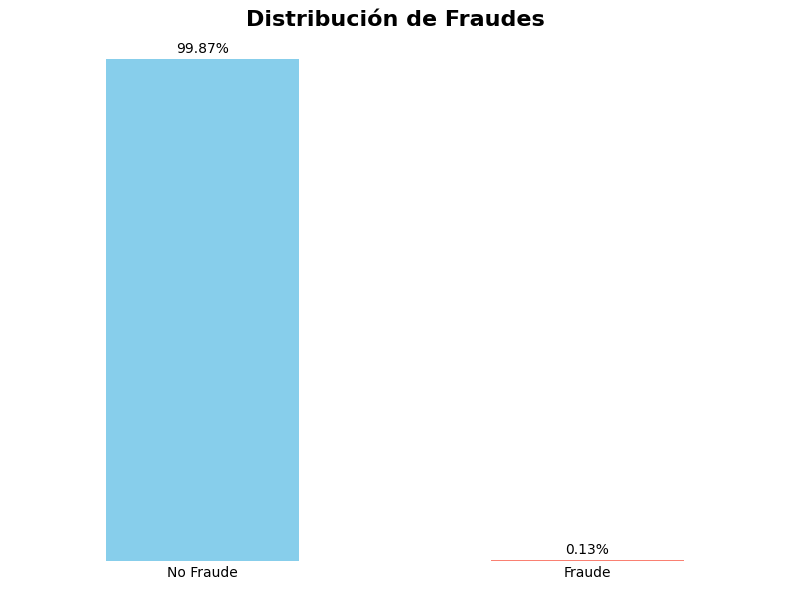

In [ ]:
#@title
conteo = df_banco['isFraud'].value_counts()

#Crear el gráfico
plt.figure(figsize=(8, 6))
ax = conteo.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='none')
plt.title('Distribución de Fraudes', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0, 1], ['No Fraude', 'Fraude'], rotation=0)
plt.tick_params(axis='y', which='both', left=False)

#Ocultar línea superior y derecha del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)

#Agregar porcentaje
total = sum(conteo)
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 80000, f"{round((i.get_height() / total) * 100, 2)}%", ha='center')

plt.grid(False)
plt.tight_layout()
plt.show()

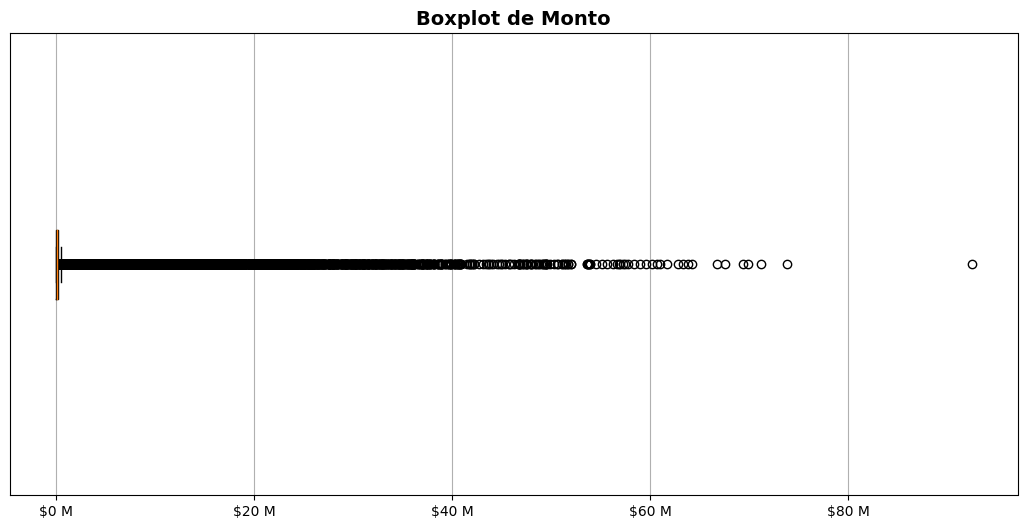

In [ ]:
# @title
#Crear el boxplot de la variable 'amount'
plt.figure(figsize=(13, 6))
plt.boxplot(df_banco['amount'], vert=False)
plt.title('Boxplot de Monto', fontsize=14, fontweight='bold')
plt.yticks([])
plt.grid(axis='x')
formatter = ticker.FuncFormatter(lambda x, _: f'${x / 1e6:.0f} M')
plt.gca().xaxis.set_major_formatter(formatter)
plt.show()

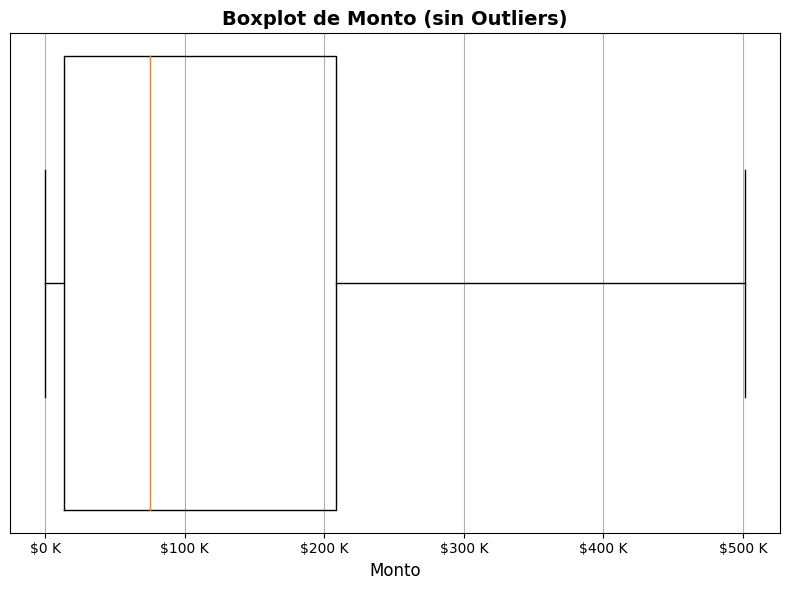

In [ ]:
# @title
#Crear el boxplot 'amount' snin outliers
plt.figure(figsize=(8, 6))
plt.boxplot(df_banco['amount'], vert=False, showfliers=False, widths=10)
plt.title('Boxplot de Monto (sin Outliers)', fontsize=14, fontweight='bold')
plt.xlabel('Monto', fontsize=12)
plt.yticks([])
plt.grid(axis='x')
formatter = ticker.FuncFormatter(lambda x, _: f'${x / 1e3:.0f} K')
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

**De los gráficos anteriores podemos concluir:**

*   Existe un **desbalanceo** muy grande entre la variable objetivo, es necesario hacer un **balanceo** mas adelante para obtener un mejor modelo.
*   Tenemos **demasiados outliers** en los **montos** de las transacciones, sin embargo la mayor concentración segun el boxplot, sin considerar outliers, se encuentra entre **10K y 210K**.

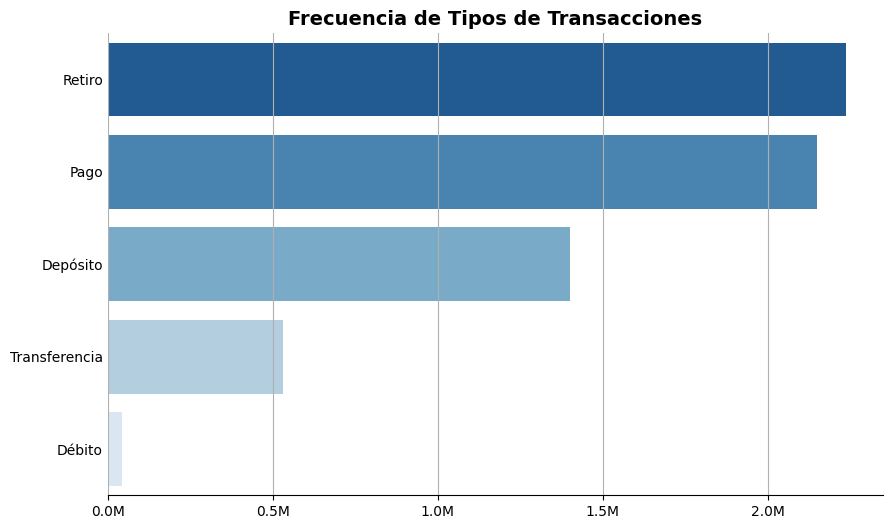

In [ ]:
frecuencia_tipos = df_banco[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].sum()

#Ordenar los valores de frecuencia de mayor a menor
frecuencia_tipos_sorted = frecuencia_tipos.sort_values(ascending=False)
plt.figure(figsize=(10, 6))

#Ajustar la paleta de colores para que la barra más grande sea un azul más fuerte
palette = sns.color_palette("Blues_r", len(frecuencia_tipos_sorted))
columnas = ['Retiro', 'Pago', 'Depósito', 'Transferencia', 'Débito']

#Dibujar el gráfico de barras horizontal
sns.barplot(x=frecuencia_tipos_sorted.values, y=columnas, palette=palette)
plt.title('Frecuencia de Tipos de Transacciones', fontsize=14, fontweight='bold')
plt.ylabel('')

#Ajustar el eje x para que muestre los valores en millones
formatter = ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M')
plt.gca().xaxis.set_major_formatter(formatter)

#Eliminar los bordes del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#Eliminar las marcas y etiquetas del eje y
plt.gca().tick_params(axis='y', length=0)
plt.grid(axis='x')
plt.show()

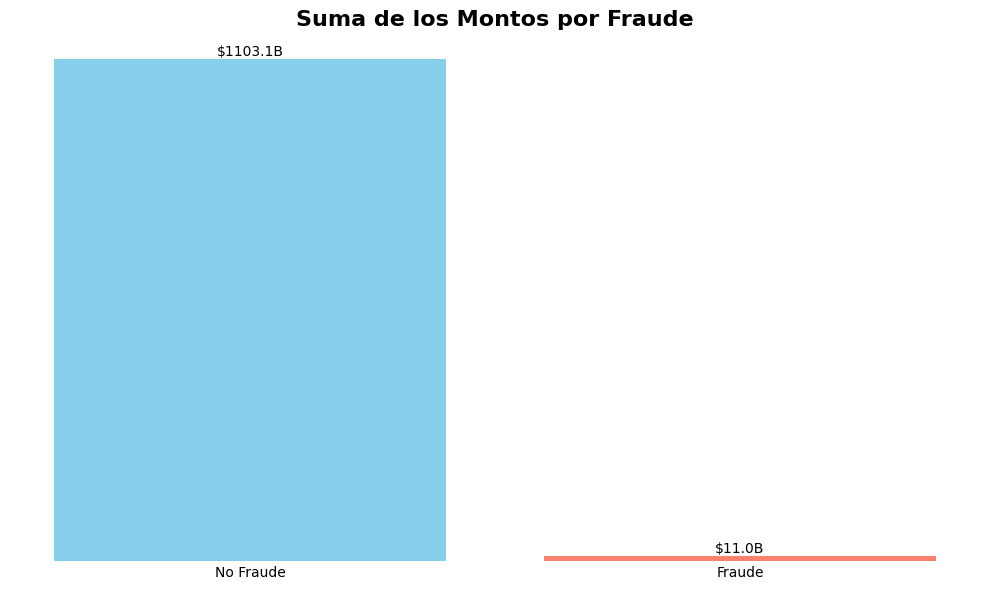

In [ ]:
#Calcular la suma de 'amount' por fraude en miles de millones
suma_no_fraude = df_banco[df_banco['isFraud'] == 0]['amount'].sum() / 1e9
suma_fraude = df_banco[df_banco['isFraud'] == 1]['amount'].sum() / 1e9

#Crear el histograma
plt.figure(figsize=(10, 6))
barplot = plt.bar(['No Fraude', 'Fraude'], [suma_no_fraude, suma_fraude], color=['skyblue', 'salmon'])
plt.title('Suma de los Montos por Fraude', fontsize=16, fontweight='bold')

#Ocultar los ejes y etiquetas
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)

# Agregar el monto
for bar, monto in zip(barplot, [suma_no_fraude, suma_fraude]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'${monto:.1f}B', ha='center', va='bottom')

plt.grid(False)
plt.tight_layout()
plt.show()

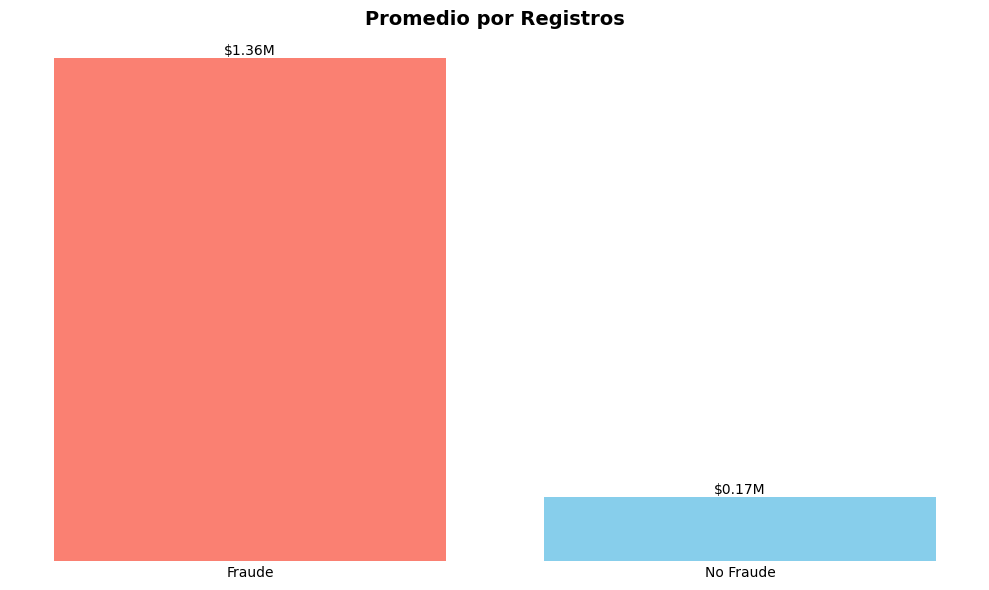

In [ ]:
# @title
#Calcula la suma de los montos para registros de fraude y no fraude
suma_montos_fraude = df_banco[df_banco['isFraud'] == 1]['amount'].sum()/1e6
suma_montos_no_fraude = df_banco[df_banco['isFraud'] == 0]['amount'].sum()/1e6

#Calcula el número de registros de fraude y no fraude
registros_fraude = df_banco['isFraud'].sum()
registros_no_fraude = len(df_banco) - registros_fraude

#Calcula el promedio por registros
razon_fraude = suma_montos_fraude / registros_fraude
razon_no_fraude = suma_montos_no_fraude / registros_no_fraude

#Grafica la razón entre la suma de montos y el número de registros para fraude y no fraude
plt.figure(figsize=(10, 6))
barplot = plt.bar(['Fraude', 'No Fraude'], [razon_fraude, razon_no_fraude], color=['salmon', 'skyblue'])
plt.title('Promedio por Registros', fontsize=14, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)


#Agrega etiquetas con el número encima de cada barra
for barra in barplot:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width() / 2, altura, f'${altura:.2f}M', ha='center', va='bottom')

plt.gca().axes.yaxis.set_ticklabels([])
plt.grid(False)
plt.tight_layout()
plt.show()

**De los dos gráficos anteriores:**

*   Aunque son pocos registros por fraude comparado con los no fraude, la suma de los montos asciende a los **11B** una cantidad fuerte al ser pocos datos.
*   De los registros que son fraudulentos, el promedio es de **$1.36M**, lo que es aproximadamente **8 veces mas** que el promedio de los registros no fraudulentos.



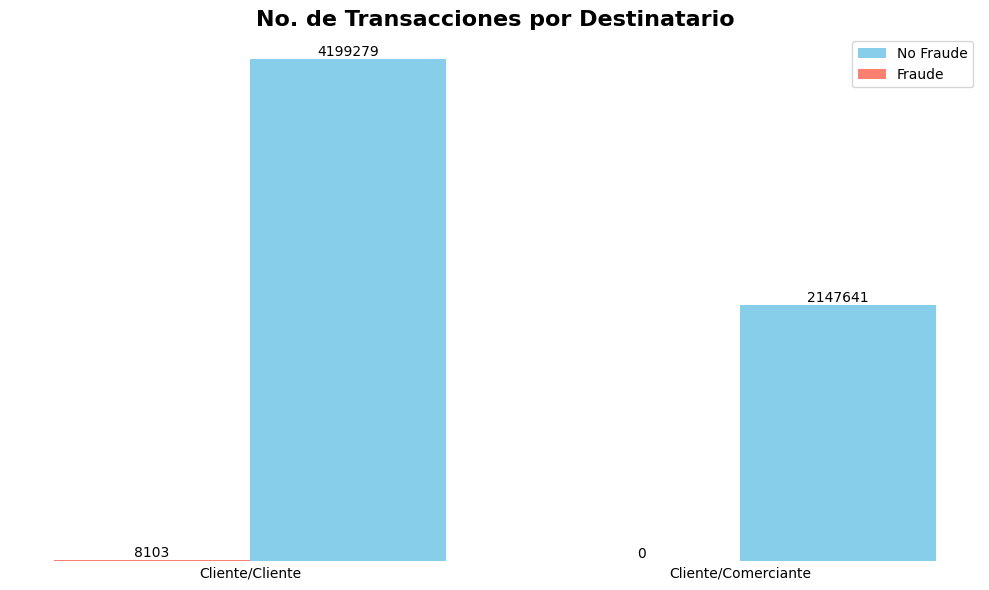

In [ ]:
# @title
#Calcular el no. total de transacciones fraudulentas y no fraudulentas por tipo de destinatario
recuento_por_tipo_fraude = df_banco[df_banco['isFraud'] == 1][['type2_CC', 'type2_CM']].sum()
recuento_por_tipo_no_fraude = df_banco[df_banco['isFraud'] == 0][['type2_CC', 'type2_CM']].sum()
plt.figure(figsize=(10, 6))

#Graficar barras para transacciones fraudulentas y no fraudulentas
bar_width = 0.4
bar_index = np.arange(len(recuento_por_tipo_fraude))

plt.bar(bar_index + bar_width/2, recuento_por_tipo_no_fraude, bar_width, label='No Fraude', color='skyblue')
plt.bar(bar_index - bar_width/2, recuento_por_tipo_fraude, bar_width, label='Fraude', color='salmon')

plt.title('No. de Transacciones por Destinatario', fontsize=16, fontweight='bold')
nombres_xticks = ['Cliente/Cliente', 'Cliente/Comerciante']
plt.xticks(bar_index, nombres_xticks)
plt.legend()

#Agregar etiquetas con el número de transacciones encima de cada barra
for i, valor in enumerate(recuento_por_tipo_fraude):
    plt.text(i - bar_width/2, valor + 3, str(valor), ha='center', va='bottom')

for i, valor in enumerate(recuento_por_tipo_no_fraude):
    plt.text(i + bar_width/2, valor + 3, str(valor), ha='center', va='bottom')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)
plt.grid(False)
plt.tight_layout()
plt.show()

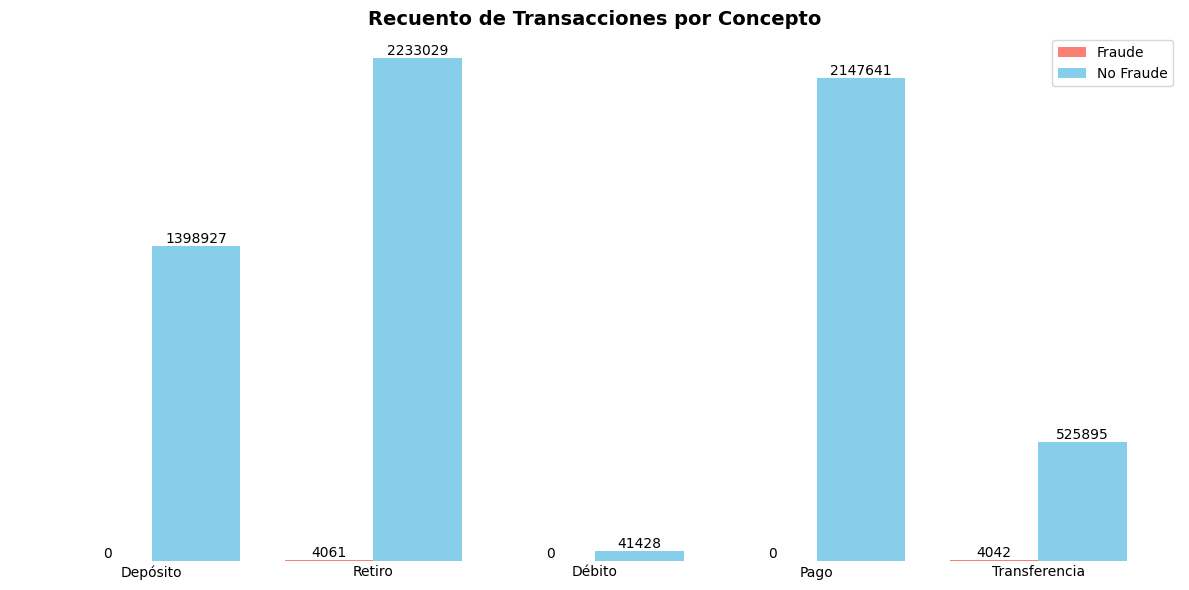

In [ ]:
# @title
#Calcular el no. total de transacciones por tipo para transacciones fraudulentas y no fraudulentas
recuento_total_fraude_por_tipo = df_banco[df_banco['isFraud'] == 1][['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].sum()
recuento_total_no_fraude_por_tipo = df_banco[df_banco['isFraud'] == 0][['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].sum()

#Crear el gráfico de barras
plt.figure(figsize=(12, 6))

#Graficar barras para transacciones fraudulentas y no fraudulentas
bar_width = 0.4
bar_index = np.arange(len(recuento_total_fraude_por_tipo))

plt.bar(bar_index - bar_width/2, recuento_total_fraude_por_tipo, bar_width, label='Fraude', color='salmon')
plt.bar(bar_index + bar_width/2, recuento_total_no_fraude_por_tipo, bar_width, label='No Fraude', color='skyblue')

plt.title('Recuento de Transacciones por Concepto', fontsize=14, fontweight='bold')
nuevas_etiquetas = ['Depósito', 'Retiro', 'Débito', 'Pago', 'Transferencia']
plt.xticks(bar_index, nuevas_etiquetas, rotation=0)

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)

#Agregar etiquetas con el número de transacciones encima de cada barra
for i in range(len(bar_index)):
    plt.text(bar_index[i] - bar_width/2, recuento_total_fraude_por_tipo[i] + 5, str(recuento_total_fraude_por_tipo[i]), ha='center', va='bottom')
    plt.text(bar_index[i] + bar_width/2, recuento_total_no_fraude_por_tipo[i] + 5, str(recuento_total_no_fraude_por_tipo[i]), ha='center', va='bottom')

plt.grid(False)
plt.tight_layout()
plt.show()

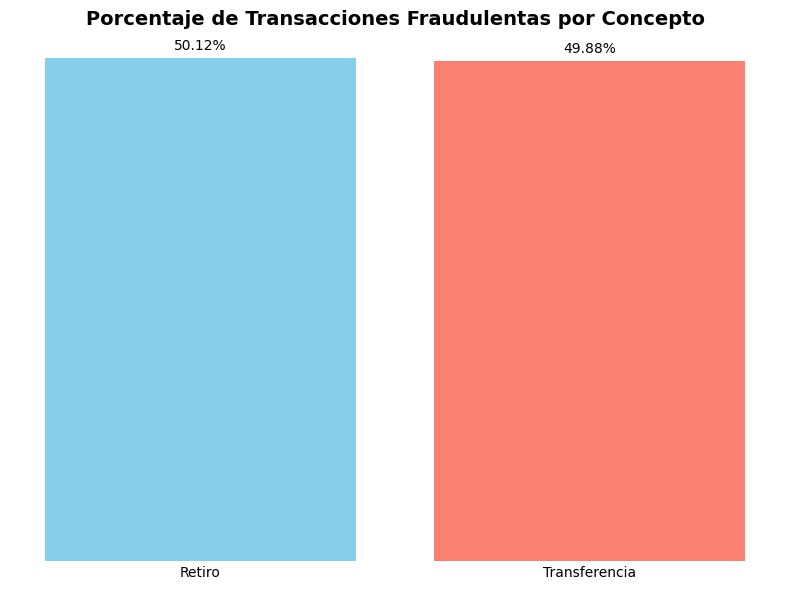

In [ ]:
# @title
#Calcular el no. total de transacciones fraudulentas por tipo
recuento_total_fraude_por_tipo = df_banco[df_banco['isFraud'] == 1][['type_CASH_OUT', 'type_TRANSFER']].sum()

#Calcular el total de transacciones fraudulentas
total_fraude = recuento_total_fraude_por_tipo.sum()

#Calcular los porcentajes de transacciones fraudulentas que son CASH_OUT y TRANSFER
porcentaje_cash_out = (recuento_total_fraude_por_tipo['type_CASH_OUT'] / total_fraude) * 100
porcentaje_transfer = (recuento_total_fraude_por_tipo['type_TRANSFER'] / total_fraude) * 100

fig, ax = plt.subplots(figsize=(8, 6))

x = ['Retiro', 'Transferencia']
x_pos = range(len(x))

#Graficar las barras
ax.bar(x_pos, [porcentaje_cash_out, porcentaje_transfer], color=['skyblue', 'salmon'])

#Agregar etiquetas de porcentaje en cada barra
for i, v in enumerate([porcentaje_cash_out, porcentaje_transfer]):
    ax.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom')

ax.set_xticks(x_pos)
ax.set_xticklabels(x)

ax.set_title('Porcentaje de Transacciones Fraudulentas por Concepto', fontsize=14, fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

In [ ]:
#Verificación de información
no_fraude, fraude = df_banco['isFraud'].value_counts()
print(f'Los registros NO fraudulentos son: {no_fraude}\nLos registros fraudulentos son: {fraude}')

Los registros NO fraudulentos son: 6346920
Los registros fraudulentos son: 8103




*   Sólo tenemos **8103 registros** catalogados como **fraude**, de los cuales fueron de cliente a cliente.
*   De dichos registros, están muy equilibradas en un 50-50 por  **Retiro** y**Transferencia**.

Es interesenta notar que no hay transacciones fraudulentas por **Cliente a Comercio**, ni por los conceptos de: **Depósito, Débito, Pago**.

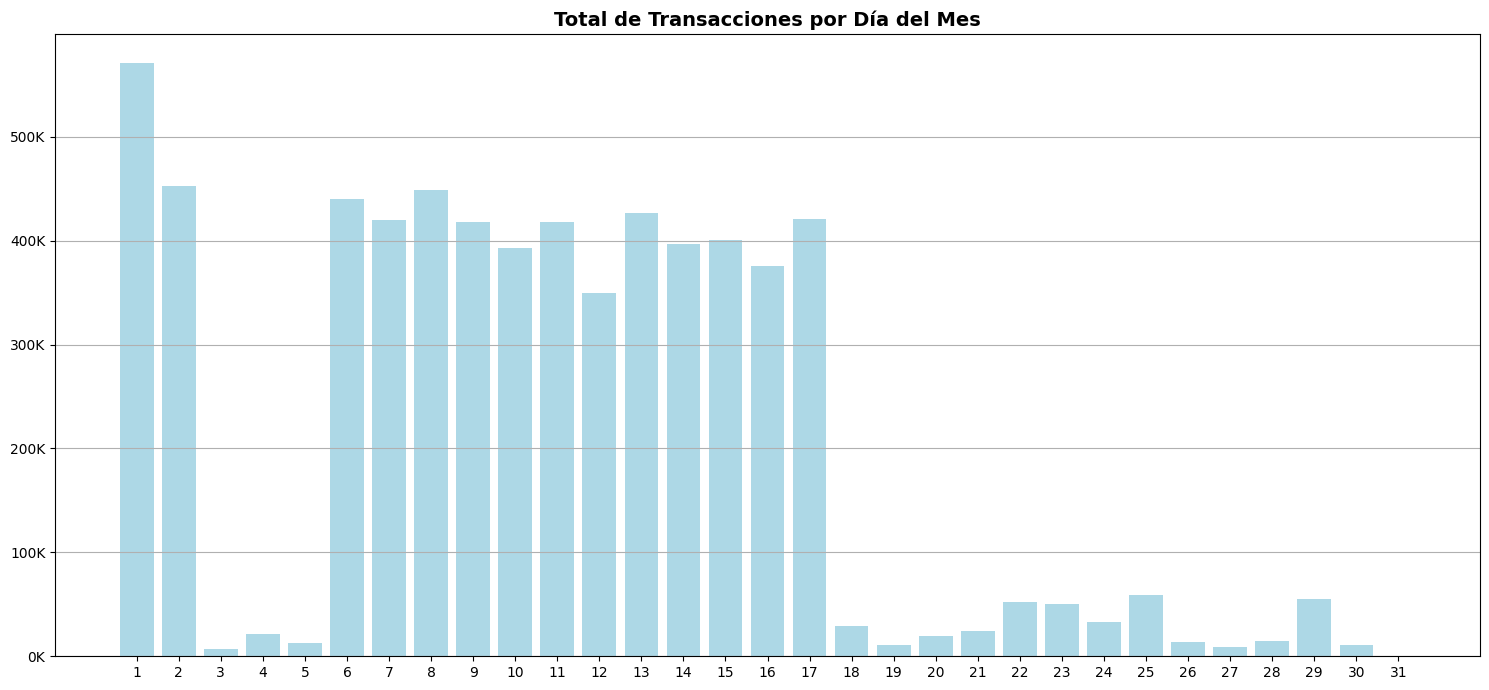

In [ ]:
#Calculamos el número total de transacciones por día
transacciones_dia = df_banco.groupby('day').size()

#Graficamos la distribución de transacciones por día
plt.figure(figsize=(15, 7))
plt.bar(transacciones_dia.index, transacciones_dia.values / 1e3, color='lightblue')

#Formatear el eje Y en miles
formatter = FuncFormatter(lambda x, _: '{:,.0f}K'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlabel('')
plt.ylabel('')
plt.title('Total de Transacciones por Día del Mes', fontsize=14, fontweight='bold')
plt.grid(axis='y')
plt.tight_layout()
plt.xticks(range(1, 32))
plt.show()



*   Una gran cantidad de transacciones ocurren los primeros días del mes, se puede deber a que a la mayoría de las personas perciben su salario mensualmente y deciden hacer transacciones.
*   También existe una gran concentración de transacciones entre los días 6-17 del mes, algunas perconas podrían recibir sus ingresos cada quince días o semanalmente.
*   Es muy común que para los días finales del mes, las personas hayan terminado con gran parte de su dinero, lo que explicaría las pocas transacciones entre los días 18-31.





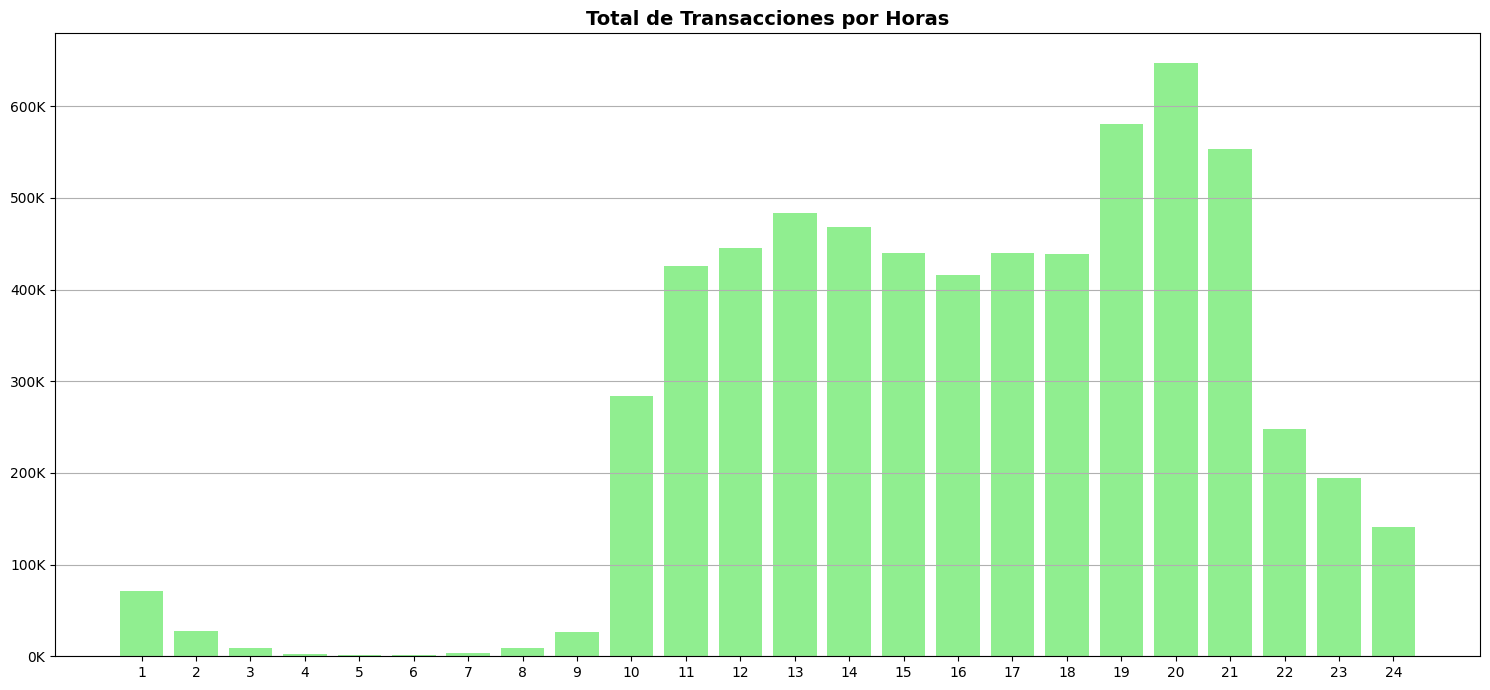

In [ ]:
#Calculamos el número total de transacciones por hora
transacciones_hora = df_banco.groupby('hour').size()

#Graficamos la distribución de transacciones por día
plt.figure(figsize=(15, 7))
plt.bar(transacciones_hora.index, transacciones_hora.values / 1e3, color='lightgreen')

#Formatear el eje Y en miles
formatter = FuncFormatter(lambda x, _: '{:,.0f}K'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlabel('')
plt.ylabel('')
plt.title('Total de Transacciones por Horas', fontsize=14, fontweight='bold')
plt.grid(axis='y')
plt.tight_layout()
plt.xticks(range(1, 25))
plt.show()

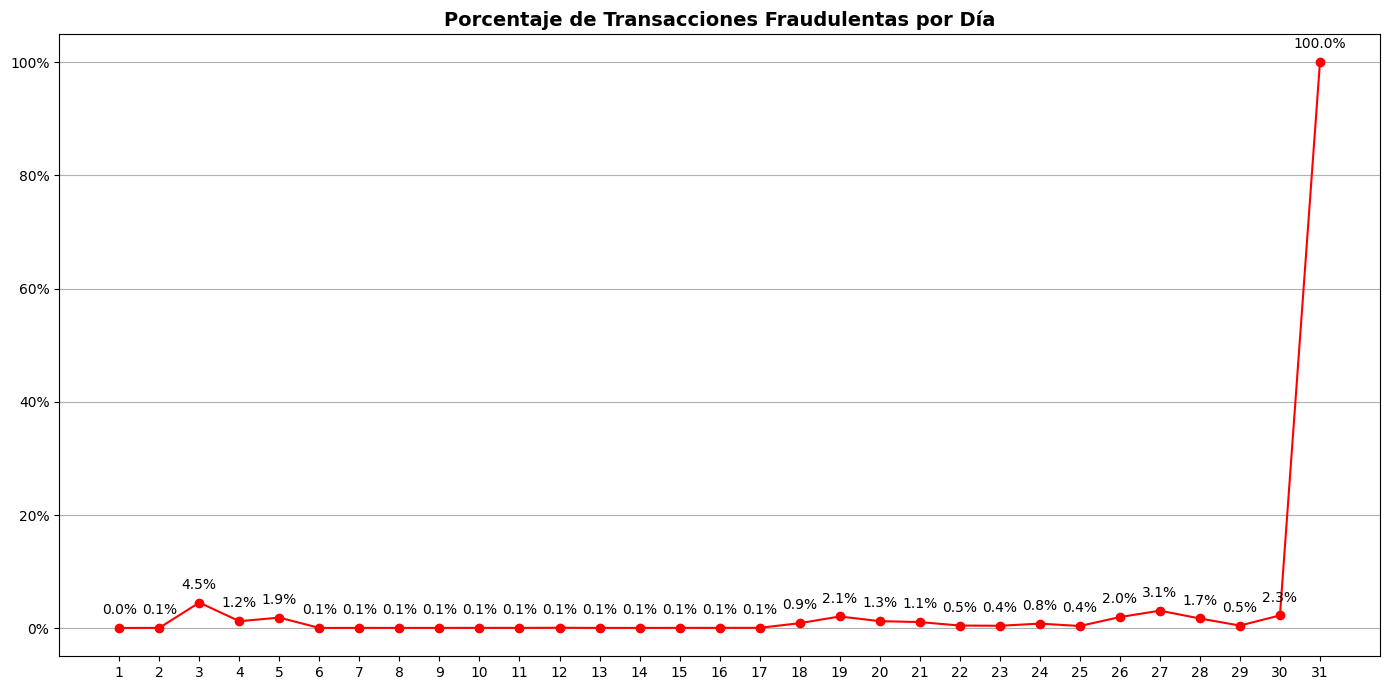

In [ ]:
#Calculamos el número de transacciones fraudulentas por día
fraudulent_transactions_per_day = df_banco[df_banco['isFraud'] == 1].groupby('day').size()

#Calculamos el número total de transacciones por día
total_transactions_per_day = df_banco.groupby('day').size()

#Calculamos la proporción de transacciones fraudulentas por día
fraud_ratio_per_day = fraudulent_transactions_per_day / total_transactions_per_day * 100

plt.figure(figsize=(14, 7))
ax = fraud_ratio_per_day.plot(kind='line', marker='o', color='red')

# Añadir etiquetas con el porcentaje encima de cada punto cuando es mayor a cero
for x, y in zip(fraud_ratio_per_day.index, fraud_ratio_per_day):
    if y > 0:
        ax.annotate(f'{y:.1f}%',
                    (x, y),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center')

plt.xlabel('')
plt.ylabel('')
plt.title('Porcentaje de Transacciones Fraudulentas por Día', fontsize=14, fontweight='bold')
plt.xticks(range(1, 32))
plt.grid(axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
plt.tight_layout()
plt.show()

In [ ]:
df_banco[df_banco['day']==31]['isFraud'].value_counts()

isFraud
1    268
Name: count, dtype: int64

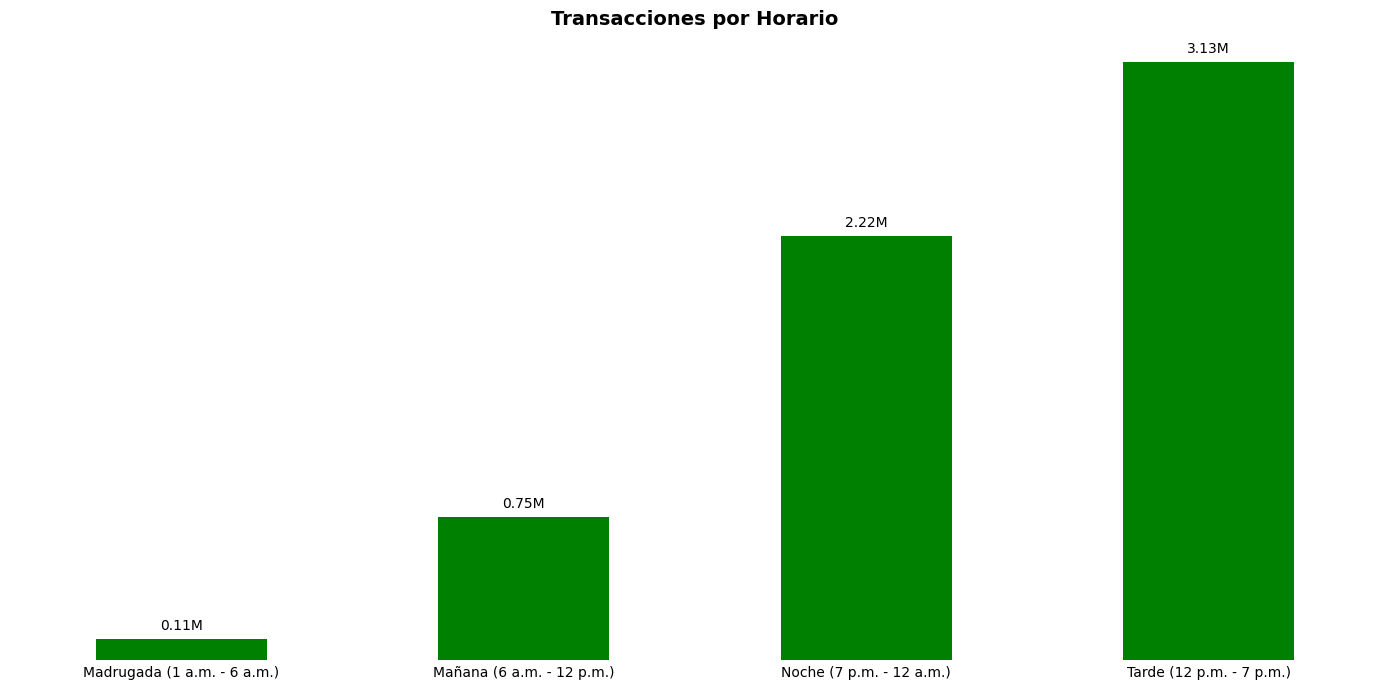

In [ ]:
ranges = {
    'Madrugada (1 a.m. - 6 a.m.)': (1, 6),
    'Mañana (6 a.m. - 12 p.m.)': (6, 12),
    'Tarde (12 p.m. - 7 p.m.)': (12, 19),
    'Noche (7 p.m. - 12 a.m.)': (19, 24)
}

#Función para asignar cada hora a su rango correspondiente
def categorize_hour(hour):
    for label, (start, end) in ranges.items():
        if start <= hour < end:
            return label
    return None

#Aplicamos la función para crear una nueva columna 'hour_range'
df_banco['hour_range'] = df_banco['hour'].apply(categorize_hour)

#Contamos el número de transacciones por rango horario
transactions_per_hour_range = df_banco.groupby('hour_range').size()

#Graficamos la distribución de transacciones por rango horario
plt.figure(figsize=(14, 7))
ax = transactions_per_hour_range.plot(kind='bar', color='green')

#Añadir etiquetas con los valores en millones encima de cada barra
for p in ax.patches:
    value_in_millions = p.get_height() / 1e6
    ax.annotate(f'{value_in_millions:.2f}M',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('')
plt.ylabel('')
plt.title('Transacciones por Horario', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.grid(False)
plt.tight_layout()
plt.show()



*   Se suelen hacer más transferencias en las tardes y noches que en la mañana y madrugada. Tiene sentido ya que es cuando las personas no se encuentran en la escuela y/o trabajo.
*   El último día del mes tuvo 268 transaciones, de las cuales todas fueron fraudulentas.

In [ ]:
df_banco.drop(columns='hour_range',inplace=True)

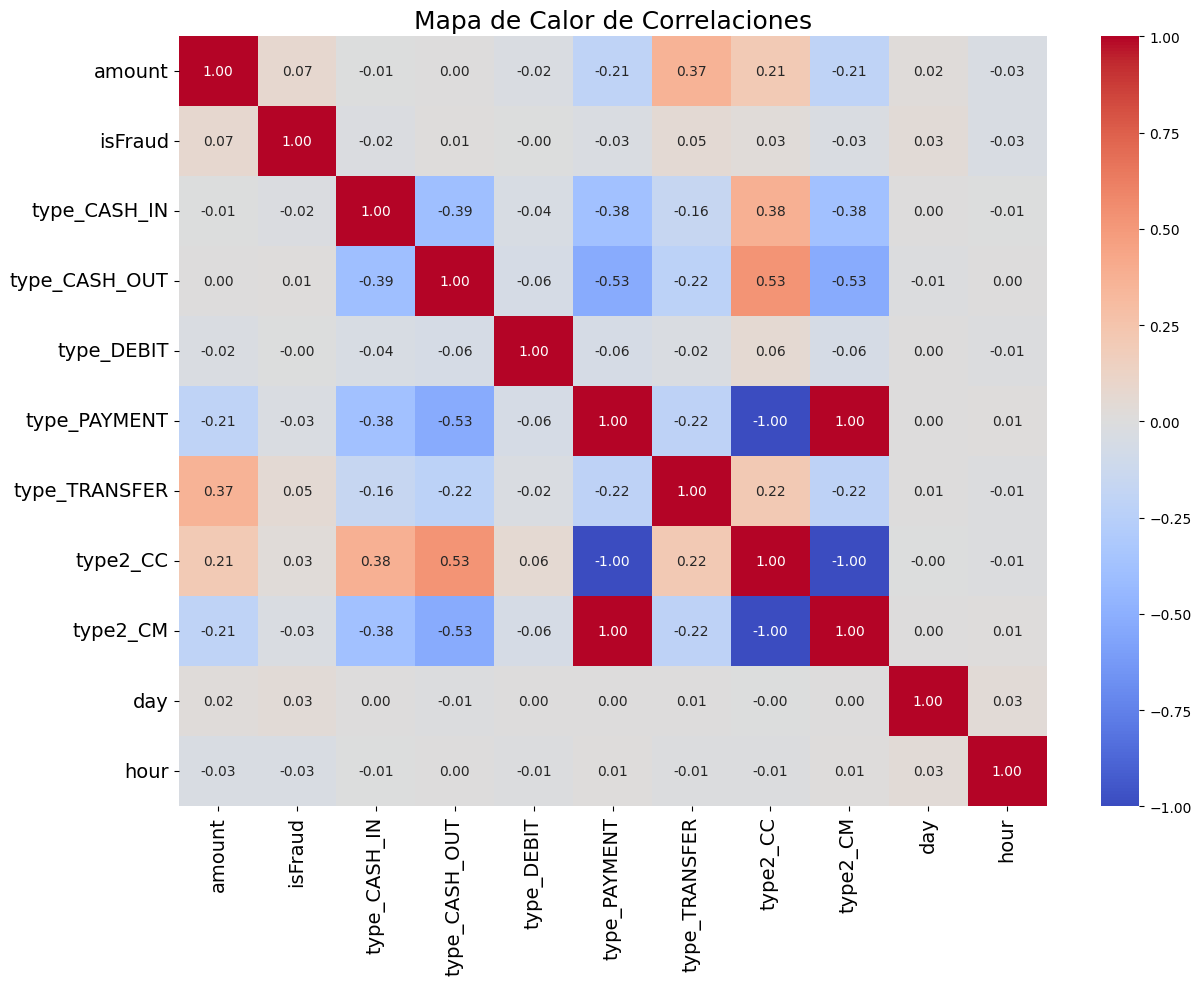

In [ ]:
# @title
plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(df_banco.corr(), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=18)
plt.show()

**Observamos como hay una alta correlación en algunas variables, más adelante veremos como reducir estos valores al quitar o dejar algunas variables en el set de datos final, después del balanceo.**

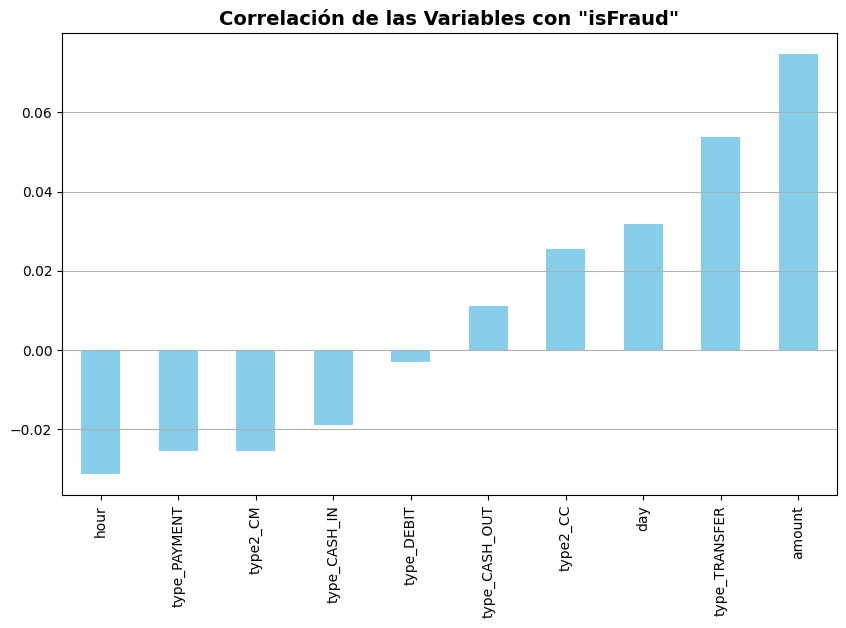

In [ ]:
# @title
# Correlación de las variables respecto a 'isFraud' excluyendo la correlación con 'isFraud' misma
correlation_series = df_banco.corr()['isFraud'].drop('isFraud')

# Graficar la correlación
plt.figure(figsize=(10, 6))
correlation_series.sort_values().plot(kind='bar', color='skyblue')
plt.title('Correlación de las Variables con "isFraud"', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.grid(axis='y')
plt.ylabel('')
plt.show()

Al parecer 'amount', 'Transfer' y 'step' son las variables mas correlacionadas con los fraudes.

**Hagamos el balanceo del conjunto de datos para reducir la brecha entre las clases fraude y no fraude.**

In [ ]:
#Función de balanceo de clases
def balanceo_clases():
  global df_banco

  #Aplicar SMOTE
  smote = SMOTE()
  X = df_banco.drop('isFraud', axis=1)
  y = df_banco['isFraud']
  X_resampled, y_resampled = smote.fit_resample(X, y)

  #Crear un nuevo df
  df_banco_balanceado = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['isFraud'])], axis=1)

  #Eliminar duplicados
  df_banco_balanceado.drop_duplicates(inplace=True)

  #Actualizar df
  df_banco = df_banco_balanceado

In [ ]:
balanceo_clases()

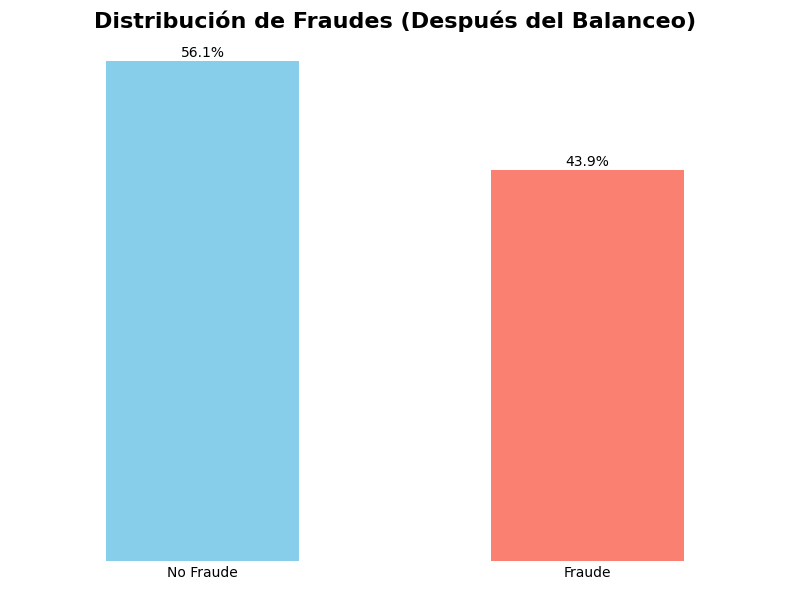

In [ ]:
conteo = df_banco['isFraud'].value_counts()

#Crear el gráfico
plt.figure(figsize=(8, 6))
ax = conteo.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='none')
plt.title('Distribución de Fraudes (Después del Balanceo)', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0, 1], ['No Fraude', 'Fraude'], rotation=0)
plt.tick_params(axis='y', which='both', left=False)

#Ocultar línea superior y derecha del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)

#Agregar porcentaje
total = sum(conteo)
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 50000, f"{round((i.get_height() / total) * 100, 2)}%", ha='center')

plt.grid(False)
plt.tight_layout()
plt.show()

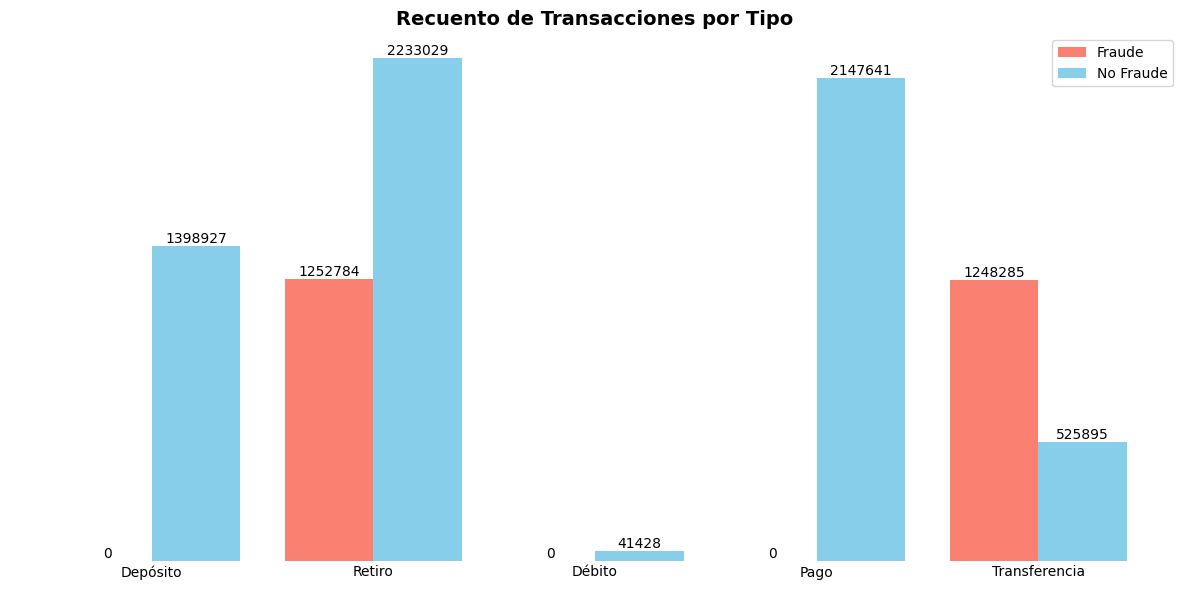

In [ ]:
#Calcular el recuento total de transacciones por tipo para transacciones fraudulentas y no fraudulentas
recuento_total_fraude_por_tipo = df_banco[df_banco['isFraud'] == 1][['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].sum()
recuento_total_no_fraude_por_tipo = df_banco[df_banco['isFraud'] == 0][['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].sum()

#Crear el gráfico de barras
plt.figure(figsize=(12, 6))

#Graficar barras para transacciones fraudulentas y no fraudulentas
bar_width = 0.4
bar_index = np.arange(len(recuento_total_fraude_por_tipo))

plt.bar(bar_index - bar_width/2, recuento_total_fraude_por_tipo, bar_width, label='Fraude', color='salmon')
plt.bar(bar_index + bar_width/2, recuento_total_no_fraude_por_tipo, bar_width, label='No Fraude', color='skyblue')

plt.title('Recuento de Transacciones por Tipo', fontsize=14, fontweight='bold')
nuevas_etiquetas = ['Depósito', 'Retiro', 'Débito', 'Pago', 'Transferencia']  # Lista de nombres personalizados
plt.xticks(bar_index, nuevas_etiquetas, rotation=0)

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)

#Agregar etiquetas con el número de transacciones encima de cada barra
for i in range(len(bar_index)):
    plt.text(bar_index[i] - bar_width/2, recuento_total_fraude_por_tipo[i] + 5, str(recuento_total_fraude_por_tipo[i]), ha='center', va='bottom')
    plt.text(bar_index[i] + bar_width/2, recuento_total_no_fraude_por_tipo[i] + 5, str(recuento_total_no_fraude_por_tipo[i]), ha='center', va='bottom')


plt.grid(False)
plt.tight_layout()
plt.show()

*   **Ahora solo tenemos diferencia de aprox 13% entre clases.**
*   **Observamos como han aumentado los registros de fraude por concepto.**



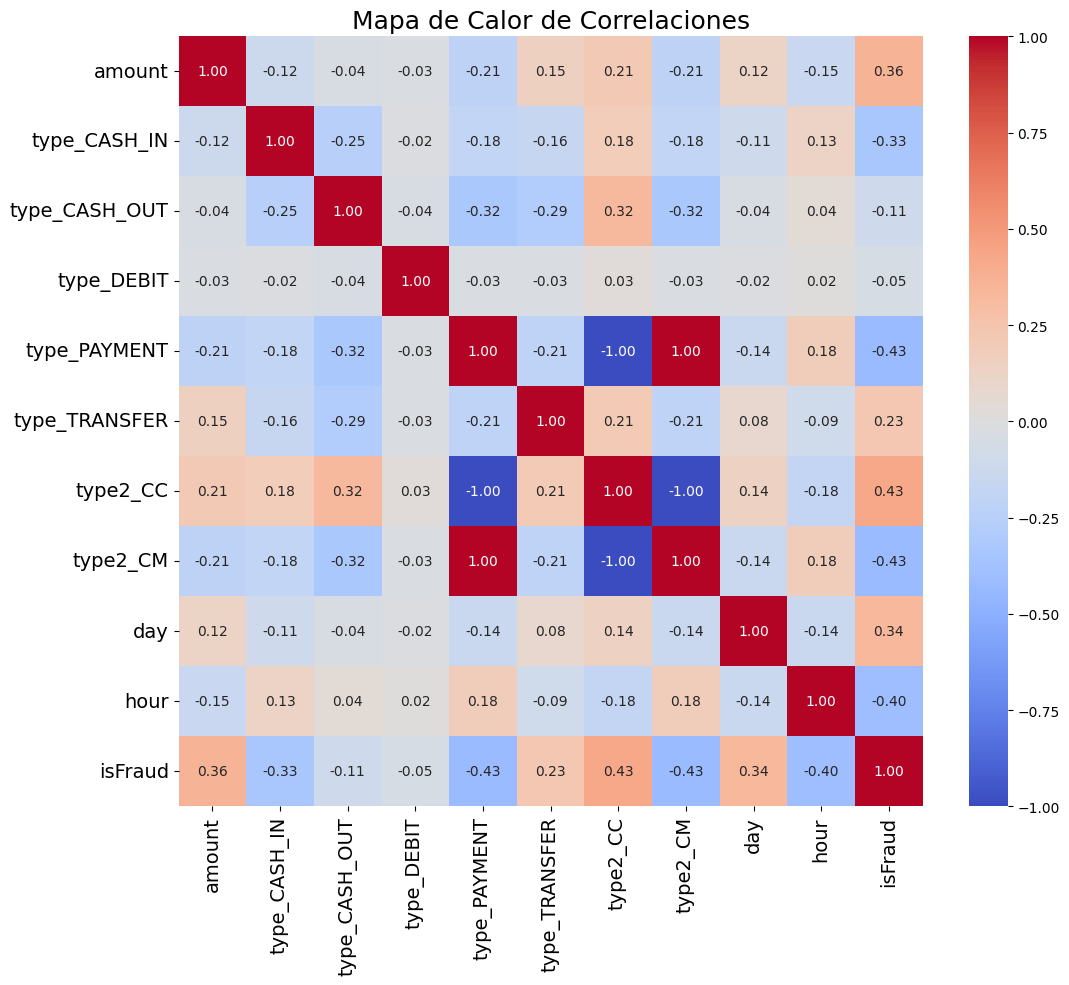

In [ ]:
#Mapa de calor balanceado
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df_banco.corr(), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=18)
plt.show()

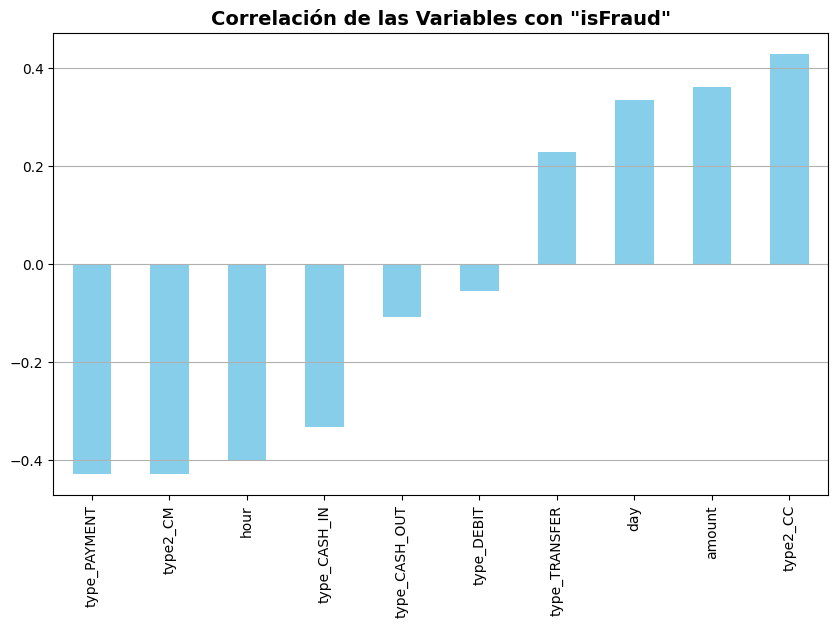

In [ ]:
#Correlación de las variables respecto a 'isFraud' excluyendo la correlación con 'isFraud' misma
correlation_series = df_banco.corr()['isFraud'].drop('isFraud')

#Graficar la correlación
plt.figure(figsize=(10, 6))
correlation_series.sort_values().plot(kind='bar', color='skyblue')
plt.title('Correlación de las Variables con "isFraud"', fontsize=14,fontweight='bold')
plt.xlabel('')
plt.grid(axis='y')
plt.ylabel('')
plt.show()

In [ ]:
#Crear un DataFrame con las variables independientes
X = df_banco.drop(columns='isFraud')
#Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

        Variable        VIF
0         amount   1.123662
1   type_CASH_IN   1.546106
2  type_CASH_OUT   1.814841
3     type_DEBIT   1.019021
4   type_PAYMENT        inf
5  type_TRANSFER   1.462363
6       type2_CC  13.596210
7       type2_CM        inf
8            day   1.075888
9           hour   1.110453


In [ ]:
columnas_irrelevantes = ['type2_CM', 'type2_CC']
df_banco.drop(columnas_irrelevantes, axis=1, inplace=True)
df_banco.head()

,amount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,day,hour,isFraud
0,9839.64,0,0,0,1,0,1,2,0
1,1864.28,0,0,0,1,0,1,2,0
2,181.00,0,0,0,0,1,1,2,1
3,181.00,0,1,0,0,0,1,2,1
4,11668.14,0,0,0,1,0,1,2,0


Hacemos uso de VIF para ver multicolinealidad entre las variables para el modelo, un alto VIF (>10 o >5) indica multicolinealidad fuerte de alguna de las variables, puede ser candidata a removerse según sea el caso.

Es importante comentar que al remover una columna y volver a analizar el VIF es muy probable que los valores cambien respecto a la iteración anterior.

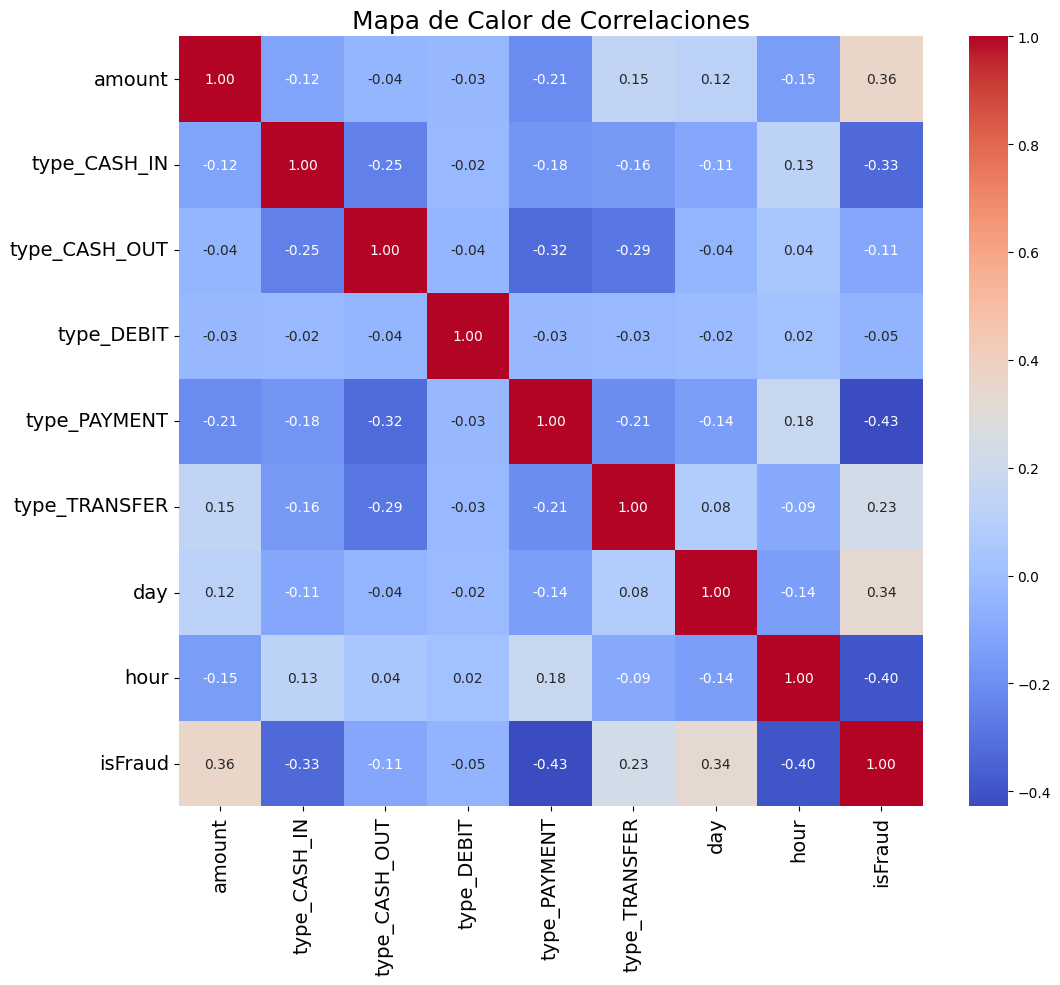

In [ ]:
#Mapa de calor nuevo
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df_banco.corr(), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=18)
plt.show()

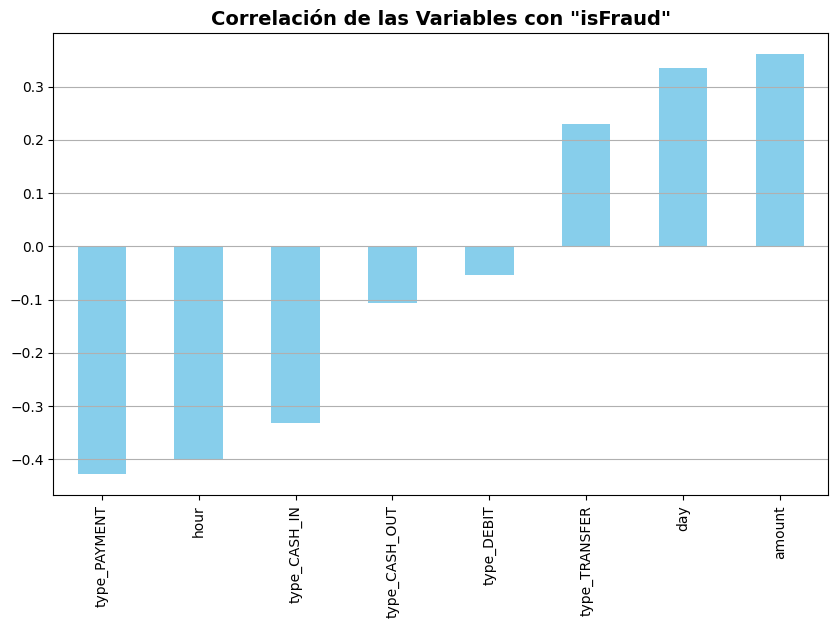

In [ ]:
#Correlación de las variables respecto a 'isFraud' excluyendo la correlación con 'isFraud' misma
correlation_series = df_banco.corr()['isFraud'].drop('isFraud')
#Graficar la correlación
plt.figure(figsize=(10, 6))
correlation_series.sort_values().plot(kind='bar', color='skyblue')
plt.title('Correlación de las Variables con "isFraud"', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.grid(axis='y')
plt.ylabel('')
plt.show()

**Esta fase de eliminación de características está sujeta a experimentación con los diferentes modelos y sus feature_importances. Cabe mencionar que las dos variables que se eliminaron (type2), ademas de tener VIF alto, no aportaban informacion importante a los dos mejores modelos, esto en base a experimentación.**

**Una vez explorado el set de datos, está listo para la construcción de modelos de aprendizaje automático.**

#**4. Construcción de Modelos**


---


Definimos nuestra función para los diferentes modelos, despuúes el entrenamiento y por último la evaluación.

In [ ]:
def entrenar_modelo(nombre, model, X_train, X_test, y_train, y_test):
    start_time = time.time()

    #Entrenamiento
    model.fit(X_train, y_train)

    #Predicciones y métricas en train
    predictions_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, predictions_train)
    prec_train = precision_score(y_train, predictions_train)
    recall_train = recall_score(y_train, predictions_train)
    f1_value_train = f1_score(y_train, predictions_train)
    auc_roc_value_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    #Predicciones y métricas en test
    predictions_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, predictions_test)
    prec_test = precision_score(y_test, predictions_test)
    recall_test = recall_score(y_test, predictions_test)
    f1_value_test = f1_score(y_test, predictions_test)
    auc_roc_value_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    matriz_test = confusion_matrix(y_test, predictions_test)

    #Determinar si hay sobreajuste
    train_auc = auc_roc_value_train
    test_auc = auc_roc_value_test
    if train_auc - test_auc > 0.1:
        overfit_msg = f"El modelo {nombre} puede estar sobreajustado."
    else:
        overfit_msg = f"El modelo {nombre} NO parece estar sobreajustado."
    print(overfit_msg)

    #Obtener importancia de características
    feature_importances = getattr(model, 'feature_importances_', None)

    #Tiempos de modelos
    end_time = time.time()
    duration = end_time - start_time

    print(f"Entrenamiento del modelo {nombre} completado. Tiempo transcurrido: {duration:.0f} segundos.\n")

    return {
        'Nombre_Modelo': nombre,
        'Accuracy_Train': accuracy_train,
        'Precision_Train': prec_train,
        'Recall_Train': recall_train,
        'F1_Score_Train': f1_value_train,
        'AUC_ROC_Train': auc_roc_value_train,
        'Accuracy_Test': accuracy_test,
        'Precision_Test': prec_test,
        'Recall_Test': recall_test,
        'F1_Score_Test': f1_value_test,
        'AUC_ROC_Test': auc_roc_value_test,
        'Feature_Importances': feature_importances,
        'Matriz_Confusión_Test': matriz_test,
        'Sobreajuste': overfit_msg
    }

def crea_modelos(df_banco, modelos):
    #Separar datos
    X = df_banco.drop(columns='isFraud')
    y = df_banco['isFraud']

    #Normalizar datos
    norm = StandardScaler()
    X_normalizado = norm.fit_transform(X)

    #Dividir datos en conjunto de entrenamiento y prueba una vez
    X_train, X_test, y_train, y_test = train_test_split(X_normalizado, y, test_size=0.3, random_state=77)

    #Entrenar modelos
    resultados = [entrenar_modelo(nombre, model, X_train, X_test, y_train, y_test) for nombre, model in modelos]

    return resultados

#Definir los modelos
modelos = [
    ('Regresión Logística', LogisticRegression()),
    ('Árbol de Decisión', DecisionTreeClassifier(max_depth=50)),
    ('Naive Bayes', GaussianNB()),
    ('Random Forest', RandomForestClassifier(n_estimators=30, max_depth=50)),
]

In [ ]:
resultados = crea_modelos(df_banco, modelos)

El modelo Regresión Logística NO parece estar sobreajustado.
Entrenamiento del modelo Regresión Logística completado. Tiempo transcurrido: 45 segundos.

El modelo Árbol de Decisión NO parece estar sobreajustado.
Entrenamiento del modelo Árbol de Decisión completado. Tiempo transcurrido: 110 segundos.

El modelo Naive Bayes NO parece estar sobreajustado.
Entrenamiento del modelo Naive Bayes completado. Tiempo transcurrido: 36 segundos.

El modelo Random Forest NO parece estar sobreajustado.
Entrenamiento del modelo Random Forest completado. Tiempo transcurrido: 1007 segundos.



**Las métricas de los datos de entrenamiento y prueba son casi identicos, lo que nos quiere decir que no tenemos un sobreajuste en los modelos, Árbol de Decisión y Random Forest tienen muy buenas métricas.**

In [ ]:
for result in resultados:
    print(f"Modelo: {result['Nombre_Modelo']}")
    print(f"Accuracy_Train: {round(result['Accuracy_Train']*100, 2)}%")
    print(f"Precisión_Train: {round(result['Precision_Train']*100, 2)}%")
    print(f"Recall_Train: {round(result['Recall_Train']*100, 2)}%")
    print(f"F1_Score_Train: {round(result['F1_Score_Train']*100, 2)}%")
    print(f"AUC-ROC_Train: {round(result['AUC_ROC_Train']*100, 2)}%")
    print(f"\nAccuracy_Test: {round(result['Accuracy_Test']*100, 2)}%")
    print(f"Precisión_Test: {round(result['Precision_Test']*100, 2)}%")
    print(f"Recall_Test: {round(result['Recall_Test']*100, 2)}%")
    print(f"F1_Score_Test: {round(result['F1_Score_Test']*100, 2)}%")
    print(f"AUC-ROC_Test: {round(result['AUC_ROC_Test']*100, 2)}%")
    print('*********************************************************************\n')

Modelo: Regresión Logística
Accuracy_Train: 90.12%
Precisión_Train: 90.72%
Recall_Train: 86.32%
F1_Score_Train: 88.46%
AUC-ROC_Train: 96.79%

Accuracy_Test: 90.09%
Precisión_Test: 90.73%
Recall_Test: 86.24%
F1_Score_Test: 88.43%
AUC-ROC_Test: 96.78%
*********************************************************************

Modelo: Árbol de Decisión
Accuracy_Train: 99.94%
Precisión_Train: 99.94%
Recall_Train: 99.93%
F1_Score_Train: 99.94%
AUC-ROC_Train: 100.0%

Accuracy_Test: 99.38%
Precisión_Test: 98.96%
Recall_Test: 99.64%
F1_Score_Test: 99.3%
AUC-ROC_Test: 99.47%
*********************************************************************

Modelo: Naive Bayes
Accuracy_Train: 75.61%
Precisión_Train: 64.28%
Recall_Train: 100.0%
F1_Score_Train: 78.26%
AUC-ROC_Train: 92.12%

Accuracy_Test: 75.63%
Precisión_Test: 64.31%
Recall_Test: 100.0%
F1_Score_Test: 78.28%
AUC-ROC_Test: 92.13%
*********************************************************************

Modelo: Random Forest
Accuracy_Train: 99.98%
Pre

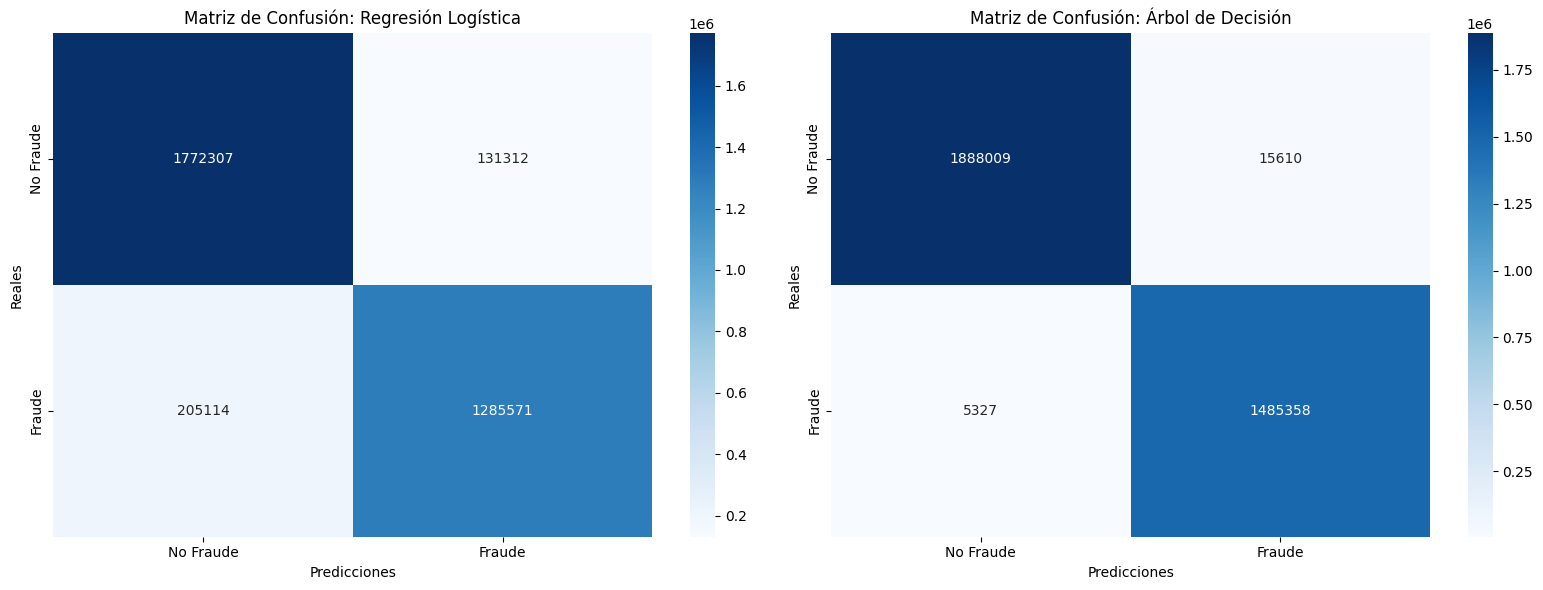

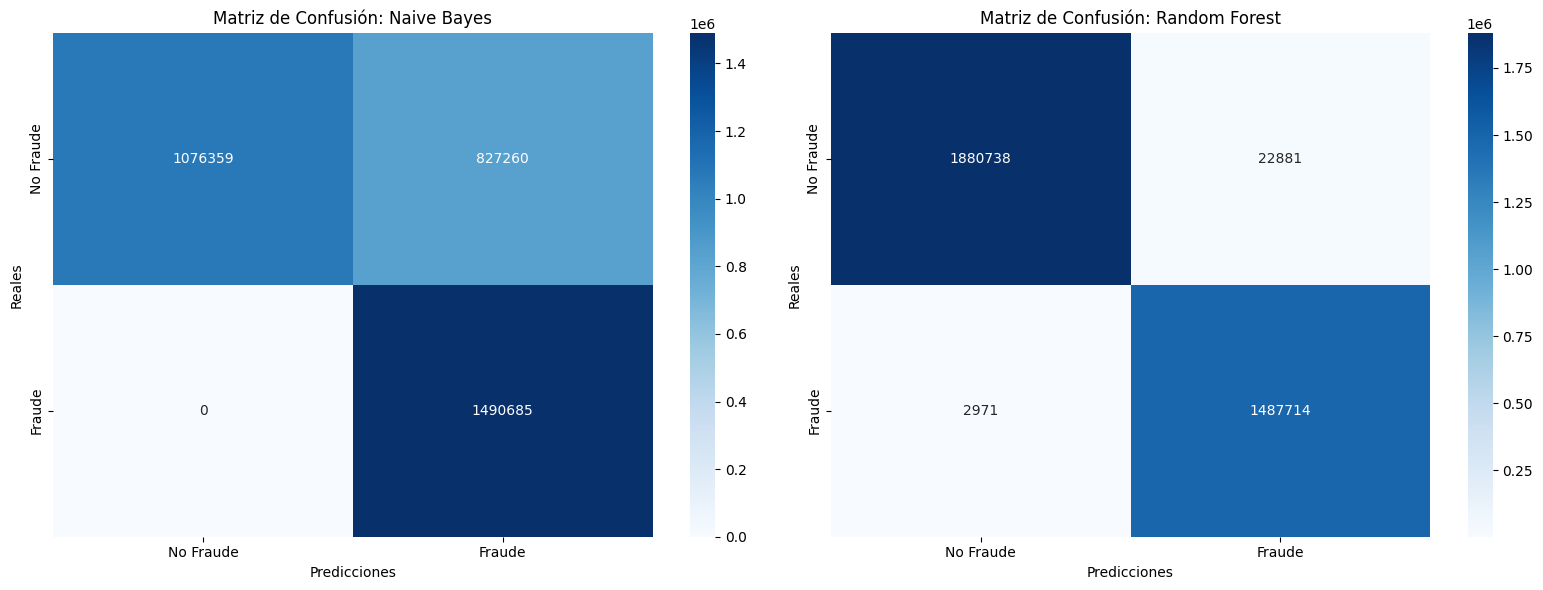

In [ ]:
#Graficar la matriz de confusión
for i in range(0, len(resultados), 2):
    plt.figure(figsize=(16, 6))

    for j in range(2):
        if i + j < len(resultados):
            matriz = resultados[i + j]['Matriz_Confusión_Test']
            plt.subplot(1, 2, j + 1)
            sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues")
            plt.title(f"Matriz de Confusión: {resultados[i + j]['Nombre_Modelo']}")
            plt.xlabel("Predicciones")
            plt.ylabel("Reales")
            plt.gca().set_xticklabels(['No Fraude', 'Fraude'])
            plt.gca().set_yticklabels(['No Fraude', 'Fraude'])

    plt.tight_layout()
    plt.show()

Observamos que los dos mejores modelos con mejores métricas son **Random Forest** y **Árbol de Decisión** con un número bajo de Falsos Negativos y buenas clasificaciones.

#**5. Evaluación y Selección del Modelo**


---


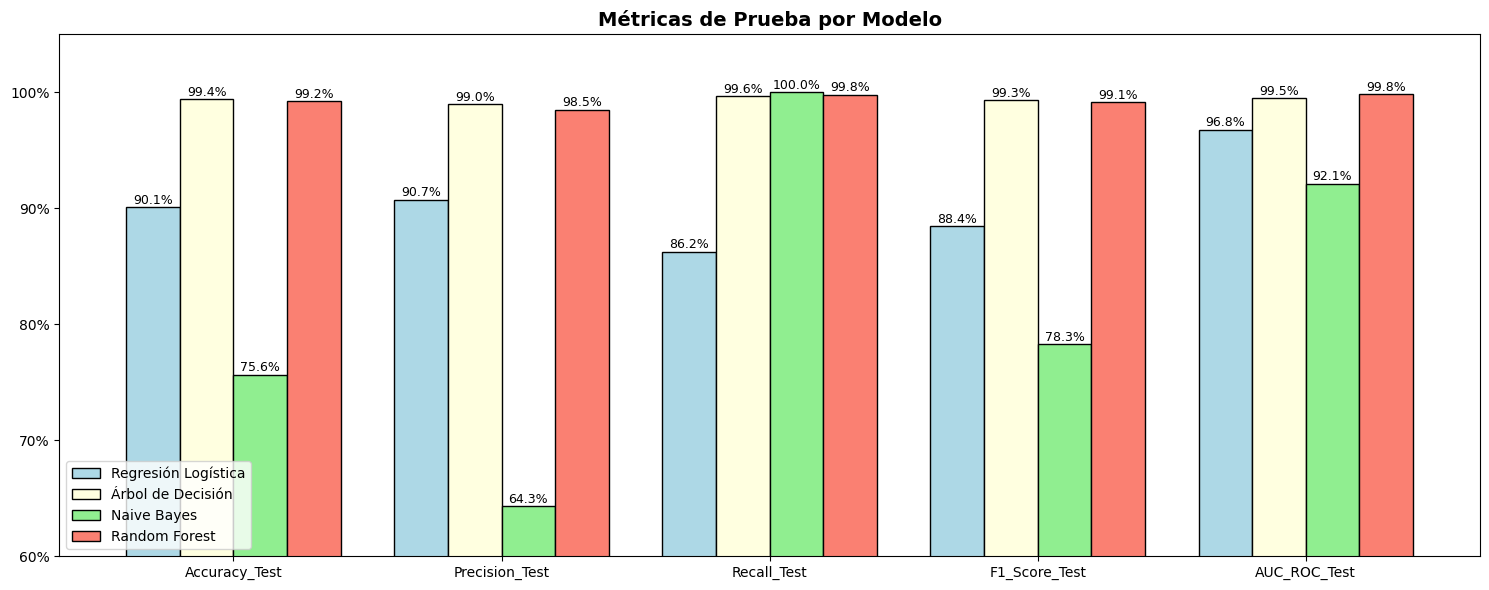

In [ ]:
def visualiza_resultados():
    global resultados

    #Transformar resultados a DataFrame
    results_df = pd.DataFrame(resultados)

    #Excluir las últimas dos columnas (matriz de confusión y feature_importances)
    results_df = results_df.iloc[:, :-2]
    results_df.set_index('Nombre_Modelo', inplace=True)

    #Seleccionar solo las métricas de prueba
    results_df = results_df[['Accuracy_Test', 'Precision_Test', 'Recall_Test', 'F1_Score_Test', 'AUC_ROC_Test']]

    #Transponer DataFrame y graficar
    results_df = results_df.T
    colors = ['lightblue', 'lightyellow', 'lightgreen', 'salmon', 'gray']

    ax = results_df.plot(kind='bar', figsize=(15, 6), colormap='viridis', rot=0, color=colors, width=0.8, edgecolor='black')
    plt.title('Métricas de Prueba por Modelo', fontsize=14, fontweight='bold')
    plt.ylim(0.6)

    #Formatear valores del eje Y como porcentajes
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

    #Agregar porcentajes encima de cada barra
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100 * p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.grid(False)
    ax.legend(loc='lower left')
    plt.show()

visualiza_resultados()

**Exactitud (Accuracy):** Esta métrica nos dice qué tan bueno es nuestro modelo para clasificar correctamente las transacciones. Por ejemplo, si nuestro modelo tiene una exactitud del 95%, significa que el 95% de las veces clasifica correctamente si una transacción es fraude o no.

**Precisión (Precision):** La precisión nos indica cuántas de las transacciones que nuestro modelo clasificó como fraude realmente son fraude. Por ejemplo, si nuestro modelo tiene una precisión del 90%, significa que el 90% de las transacciones que clasificó como fraude realmente lo son.

**Recuperación o Sensibilidad (Recall o Sensitivity):** La recuperación nos dice cuántas de las transacciones de fraude en realidad nuestro modelo identificó correctamente. Por ejemplo, si nuestro modelo tiene una recuperación del 85%, significa que identificó correctamente el 85% de todas las transacciones fraudulentas.

**Puntuación F1 (F1-Score):** Esta métrica combina precisión y recuperación en un solo número. Es útil cuando queremos encontrar un equilibrio entre estas dos métricas. Por ejemplo, si tenemos una puntuación F1 del 87%, indica un buen equilibrio entre identificar correctamente las transacciones fraudulentas y no clasificar incorrectamente las transacciones no fraudulentas.

**Área bajo la curva ROC (AUC-ROC):** Mide cuán bien puede distinguir nuestro modelo entre transacciones fraudulentas y no fraudulentas. Un valor alto de AUC-ROC, digamos 0.9, significa que nuestro modelo es muy bueno para distinguir entre las dos clases, lo que es importante para la detección de fraudes, donde queremos minimizar tanto los falsos positivos como los falsos negativos.

### **Hemos decidido escoger el modelo Random Forest por sus buenas métricas en general.** Aunque Árbol de Decisión tambien obtuvo buenas métricas y en un tiempo menor, consideramos que Random Forest se acopla mejor al problema de negocio para grandes cantidades de datos

En este caso, Recall es una métrica clave para poder disminuir el numero de fraudes NO detectados correctamente como fraude.

#**6. Conclusiones**


---


En este proyecto, hemos desarrollado un modelo de clasificación binaria para la detección de fraudes bancarios. Tras un análisis exhaustivo de varias técnicas de aprendizaje automático, determinamos que el modelo Random Forest era la opción más apropiada debido a sus ventajas específicas en términos de métricas de desempeño y capacidad de generalización en conjuntos de datos grandes, complejos y desequilibrados.

## **Resultados Clave**

1. **Precisión y Recall:** El modelo Random Forest demostró una alta precisión y un recall significativo, lo cual es crucial en la detección de fraudes, donde la identificación correcta de transacciones fraudulentas es esencial para mitigar pérdidas financieras y mantener la confianza del cliente.
2. **AUC-ROC:** El área bajo la curva ROC (AUC-ROC) del modelo Random Forest fue significativamente alto, indicando una capacidad robusta para distinguir entre transacciones legítimas y fraudulentas en todo el rango de umbrales de clasificación.

## **Ventajas del Random Forest**

- **Mejora del Rendimiento Predictivo:** La combinación de múltiples árboles de decisión en un bosque aleatorio ayuda a mejorar el rendimiento predictivo del modelo, reduciendo así el riesgo de sobreajuste y mejorando la generalización a nuevos datos.
- **Robustez ante Datos Desequilibrados:** El Random Forest maneja eficazmente conjuntos de datos con desequilibrio de clases, como es común en la detección de fraudes, donde las transacciones fraudulentas son relativamente raras en comparación con las legítimas.

## **Implicaciones Prácticas**

La implementación de este modelo en un entorno bancario puede mejorar significativamente la capacidad de detectar y prevenir fraudes, reduciendo así las pérdidas económicas y aumentando la confianza de los clientes en la seguridad de las transacciones.

## **Consideraciones Futuras**

Sería beneficioso continuar evaluando y mejorando el modelo utilizando conjuntos de datos más grandes y variados, así como explorar técnicas adicionales de preprocesamiento de datos y ajuste de hiperparámetros para mejorar aún más su desempeño en diferentes contextos bancarios y en un entorno de producción.

En conclusión, el uso del algoritmo **Random Forest** para la detección de fraudes bancarios ha demostrado ser una elección acertada, proporcionando un balance óptimo entre precisión, capacidad de generalización y eficiencia, lo que lo convierte en una herramienta valiosa para combatir el fraude en el sector bancario.